In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re
from attrdict import AttrDict

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
varinfo.clear()

dout = 'gnn_abcd/'

In [3]:
varinfo.Y1_m = dict(bins=np.linspace(0,1000,30))
varinfo.Y2_m = dict(bins=np.linspace(0,1000,30))

varinfo.H1Y1_m = dict(bins=np.linspace(0,300,30))
varinfo.H2Y1_m = dict(bins=np.linspace(0,300,30))
varinfo.H1Y2_m = dict(bins=np.linspace(0,300,30))
varinfo.H2Y2_m = dict(bins=np.linspace(0,300,30))


In [4]:
bkgtrees = ObjIter([Tree(filter(os.path.isfile,fc.eightb.preselection_golden.QCD_B_List))])
# bkgtrees = ObjIter([Tree(filter(os.path.isfile,fc.eightb.preselection.QCD_B_List))])
# bkgtrees = ObjIter([])

In [5]:
signaltrees = ObjIter([ Tree(f) for i,f in enumerate(fc.eightb.preselection_golden.signal_list) if i in (0,5,7) ])

In [6]:
for signal in signaltrees: signal.color = None

In [7]:
(bkgtrees + signaltrees).apply(lambda t : build_collection(t, 'Y\d', 'y'))
(bkgtrees + signaltrees).apply(lambda t : build_collection(t, 'H\dY\d', 'higgs'))
(bkgtrees + signaltrees).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'bjet'))

[None, None, None, None]

In [8]:
def btag_multi(tree):
    btag = tree.bjet_btag
    n_mbtag = ak.sum( btag > jet_btagWP[2],axis=-1) 
    n_lbtag = ak.sum( (btag > jet_btagWP[1]) & (btag < jet_btagWP[2]), axis=-1)
    n_nbtag = ak.sum( btag < jet_btagWP[1], axis=-1)

    btagsum = ak.sum( btag,axis=-1)
    tree.extend(n_medium_btag=n_mbtag, n_loose_btag=n_lbtag, n_null_btag=n_nbtag, btagsum=btagsum)
(bkgtrees+signaltrees).apply(btag_multi)

[None, None, None, None]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


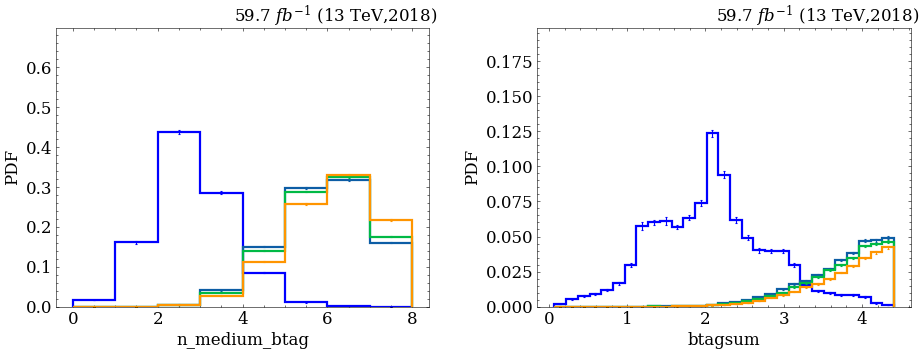

In [9]:
study.quick(
    (bkgtrees+signaltrees),
    varlist=['n_medium_btag','btagsum'],
    density=True,
)

In [10]:
geq4_mbtag = lambda t : t.n_medium_btag >= 4
eq3_mbtag = lambda t : t.n_medium_btag == 3
leq2_mbtag = lambda t : t.n_medium_btag <= 2

In [11]:
objlist = ['X','Y1','H1Y1','H2Y1',None,'Y2','H1Y2','H2Y2']

In [12]:
var_asym = lambda x,y : (x-y)/(x+y)
var_diff = lambda x,y : x-y

def var_diffs(var):
    nobj = ak.count(var,axis=-1)[0]
    return ak.concatenate([ var_diff(var[:,i],var[:,j])[:,None] for i in range(nobj) for j in range(i+1, nobj) ],axis=-1)

def var_asyms(var):
    nobj = ak.count(var,axis=-1)[0]
    return ak.concatenate([ var_asym(var[:,i],var[:,j])[:,None] for i in range(nobj) for j in range(i+1, nobj) ],axis=-1)

def dphis(phis):
    nobj = ak.count(phis,axis=-1)[0]
    return ak.concatenate([ calc_dphi(phis[:,i],phis[:,j])[:,None] for i in range(nobj) for j in range(i+1, nobj) ],axis=-1)
    
def y_diffs(tree):
    y_deta = var_diffs(tree.y_eta)
    
    y_dphi = dphis(tree.y_phi)
                                
    y_dr = np.sqrt( y_deta**2+y_dphi**2) 
     
    y_dm = var_asyms(tree.y_m)
    
    y_dpt = var_asyms(tree.y_pt)
    
    tree.extend(**{ key:value for key,value in locals().items() if isinstance(value, ak.Array)})


def higgs_diffs(tree):
    hij_deta = var_diffs(tree.higgs_eta)
    h_detasum = np.sqrt( np.sum(hij_deta**2,axis=-1) )
    
    hij_dphi = dphis(tree.higgs_phi)
    h_dphisum = np.sqrt( np.sum(hij_dphi**2,axis=-1))
                                
    hij_dr = np.sqrt( hij_deta**2+hij_dphi**2) 
    h_drsum = np.sqrt( np.sum(hij_dr**2,axis=-1))
     
    hij_dm = var_asyms(tree.higgs_m)
    h_dmsum = np.sqrt(np.sum(hij_dm**2,axis=-1))
    
    hij_dpt = var_asyms(tree.higgs_pt)
    h_dptsum = np.sqrt(np.sum(hij_dpt**2,axis=-1))
    
    tree.extend(**{ key:value for key,value in locals().items() if isinstance(value, ak.Array)})


def bjet_diffs(tree):
    bij_deta = var_diffs(tree.bjet_eta)
    b_detasum = np.sqrt( np.sum(bij_deta**2,axis=-1) )
    
    bij_dphi = dphis(tree.bjet_phi)
    b_dphisum = np.sqrt( np.sum(bij_dphi**2,axis=-1))
                                
    bij_dr = np.sqrt( bij_deta**2+bij_dphi**2) 
    b_drsum = np.sqrt( np.sum(bij_dr**2,axis=-1))
     
    bij_dm = var_asyms(tree.bjet_m)
    b_dmsum = np.sqrt(np.sum(bij_dm**2,axis=-1))
    
    bij_dpt = var_asyms(tree.bjet_pt)
    b_dptsum = np.sqrt(np.sum(bij_dpt**2,axis=-1))
    
    tree.extend(**{ key:value for key,value in locals().items() if isinstance(value, ak.Array)})

(bkgtrees+signaltrees).apply(y_diffs)
(bkgtrees+signaltrees).apply(higgs_diffs)
(bkgtrees+signaltrees).apply(bjet_diffs)


[None, None, None, None]

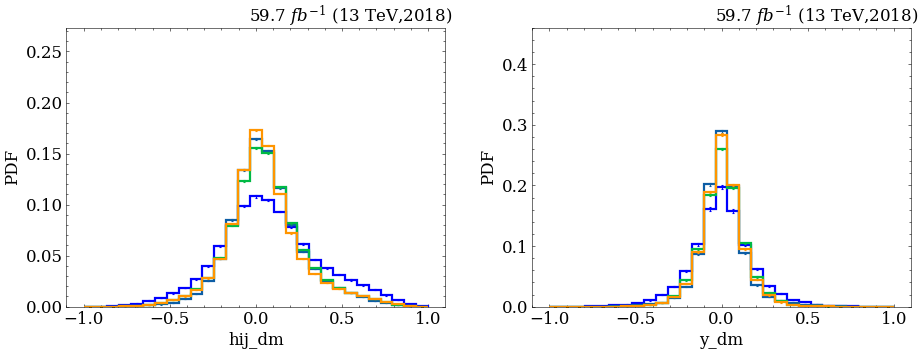

In [13]:
study.quick(
    (bkgtrees+signaltrees),
    varlist=["hij_dm","y_dm"],
    binlist=[np.linspace(-1,1,30)]*2,
    density=True,
)

In [14]:
def build_raw_features(tree):
    hij_dm = tree.hij_dm.to_numpy()
    y_dm = tree.y_dm.to_numpy()
    return np.concatenate([hij_dm,y_dm],axis=-1)

In [15]:
features = np.concatenate(signaltrees.apply(build_raw_features).list)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

training, testing = train_test_split(features, shuffle=True, test_size=0.2)
training, validation = train_test_split(training, shuffle=True, test_size=0.2)

scaler = StandardScaler().fit(training)

training = scaler.transform(training)
validation = scaler.transform(validation)
testing = scaler.transform(testing)

trainloader = DataLoader(training, batch_size=100, num_workers=16)
validloader = DataLoader(validation, batch_size=100, num_workers=16)
testloader  = DataLoader(testing, batch_size=100, num_workers=16)


In [17]:
from pytorch_lightning import LightningModule, Trainer
from torchmetrics.functional import accuracy, auroc
import torch

class AutoEncoder(LightningModule):
    def __init__(self, n_in_features=7, internal=[128,64,32], n_out_features=2):
        super().__init__()

        nn_list = [n_in_features] + internal + [n_out_features]

        encoder_list = [
            layer(nn_in, nn_out) if layer == torch.nn.Linear else layer()
            for nn_in, nn_out in zip(nn_list[:-1],nn_list[1:])
            for layer in (torch.nn.Linear,torch.nn.ReLU)
        ][:-1]

        self.encoder = torch.nn.Sequential(*encoder_list)

        nn_list = nn_list[::-1]
        decoder_list = [
            layer(nn_in, nn_out) if layer == torch.nn.Linear else layer()
            for nn_in, nn_out in zip(nn_list[:-1],nn_list[1:])
            for layer in (torch.nn.Linear,torch.nn.ReLU)
        ][:-1]
        self.decoder = torch.nn.Sequential(*decoder_list)

    def encode(self, data): return self.encoder(data)
    def decode(self, data): return self.decoder(data)

    def forward(self, data):
        encoded = self.encoder(data)
        decoded = self.decoder(encoded)
        return decoded

    def step(self, batch, batch_idx):
        output = self(batch)
        loss = ((batch - output)**2).sum()
        self.log('chi2',loss)
        return loss

    def predict(self, data):
        output = self(data)
        return torch.exp(output[:,1])

    def training_step(self, batch, batch_idx): return self.step(batch, batch_idx)
    def test_step(self, batch, batch_idx): return self.step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [39]:
model = AutoEncoder(n_in_features=7, n_out_features=4)
trainer = Trainer(gpus=1, max_epochs=10)
trainer.fit(model, trainloader, validloader)
trainer.test(model, testloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 11.5 K
1 | decoder | Sequential | 11.5 K
---------------------------------------
23.0 K    Trainable params
0         Non-trainable params
23.0 K    Total params
0.092     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 1081/1081 [00:10<00:00, 105.16it/s, loss=85.9, v_num=6]    


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 338/338 [00:01<00:00, 290.78it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'chi2': 93.37528228759766}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 338/338 [00:01<00:00, 174.18it/s]


[{'chi2': 93.37528228759766}]

In [40]:
def build_features(tree, scaler=scaler):
    features = build_raw_features(tree)
    features = scaler.transform(features)
    return features

In [41]:
def encode_tree(tree, model=model):
    features = build_features(tree)
    with torch.no_grad():
        return ak.from_numpy(model.encode( torch.Tensor(features)).numpy())

In [42]:
encoded_features = (bkgtrees+signaltrees).apply(encode_tree)

In [43]:
weights = (bkgtrees+signaltrees).scale.list

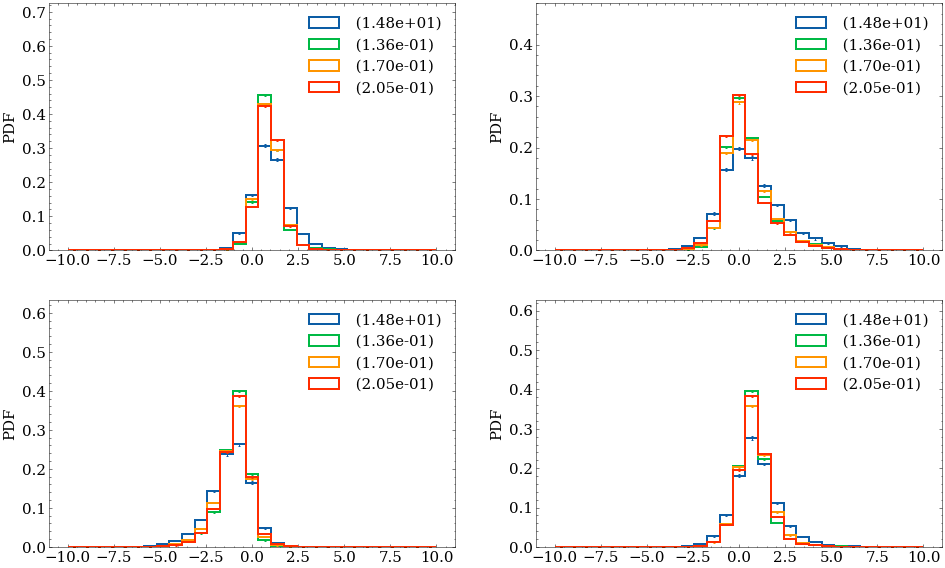

In [44]:
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(16,10))

for x in range(4):
    encoded_x = encoded_features.apply(lambda a : a[:,x]).list
    hist_multi(encoded_x,weights=weights, density=True, legend=True, bins=np.linspace(-10,10,30), figax=(fig,axs.flat[x]))